<a href="https://colab.research.google.com/github/jmhuer/Fall2021MusicResearch/blob/main/HarmonyReductionAndDecompostion/rulebased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pretty_midi
# !git clone https://github.com/jmhuer/ModularSparseAutoencoder
# !git clone https://github.com/music-x-lab/POP909-Dataset
!git clone https://github.com/jmhuer/HT
!git clone https://github.com/Tsung-Ping/functional-harmony
# %cd /content/POP909-Dataset/data_process
!pip install libfmp

fatal: destination path 'HT' already exists and is not an empty directory.
fatal: destination path 'functional-harmony' already exists and is not an empty directory.


#Download Data

In [5]:
from HT.BPS_FH_preprocessing import main

main()

Message: load note data ...
lowest pitch = 24 highest pitch =  101
Message: load chord labels...
Message: get framewise labels ...
max_length = 8482
min_length = 872
keys in corpus['op'] = dict_keys(['pianoroll', 'chromagram', 'start_time', 'label'])
label fields =  [('op', '<U10'), ('onset', '<f8'), ('key', '<U10'), ('degree1', '<U10'), ('degree2', '<U10'), ('quality', '<U10'), ('inversion', '<i8'), ('rchord', '<U10'), ('root', '<U10'), ('tquality', '<U10'), ('chord_change', '<i8')]
Running Message: augment data...
keys in corpus_aug['shift_id']['op'] = dict_keys(['pianoroll', 'tonal_centroid', 'start_time', 'label'])
Running Message: reshape data...
keys in corpus_aug_reshape['shift_id']['op'] = dict_keys(['pianoroll', 'tonal_centroid', 'start_time', 'label', 'len'])
sequence_len_non_overlaped = [17, 22, 23, 24, 30, 34, 36, 40, 44, 48, 52, 53, 66, 72, 80, 84, 86, 88, 100, 102, 104, 116, 118, 120, 128]
sequence_len_overlaped = [17, 22, 23, 24, 30, 34, 36, 40, 44, 48, 52, 53, 66, 72, 8

In [6]:
# !pip install tensorflow-gpu==1.15
from HT.chord_symbol_recognition import train_HT
from collections import Counter, namedtuple
from HT.BPS_FH_preprocessing import main
from HT.chord_symbol_recognition import load_data_symbol
#

import pickle
import os
import sys
# import utils
import pretty_midi 
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch


class BPS(Dataset):
    def __init__(self, data):
        "todo: transpose"
        self.all_data = []
        temp = []
        self.label = []
        temp2 = []
        self.chord_change = []
        temp3 = []      
        i = 0 
        for pi,chord, cc in zip(data["pianoroll"],data["tchord"],data['label']['chord_change']):
            temp.append(torch.tensor(pi[None,:,12:76]).double())
            temp2.append(torch.tensor(chord).double())
            temp3.append(torch.tensor(cc).double())
            i+=1
            # if i > 30000: break
        self.all_data = torch.stack(temp).permute(0,1,3,2)
        self.label = torch.stack(temp2)
        self.chord_change = torch.stack(temp3)
        print("data" , self.all_data.shape)
        print("label" , self.label.shape)
        ##time.sleep(120)
        self.transform = self.make_transform()
    def __len__(self):
        return len(self.all_data)
    def __getitem__(self, idx):
        piano_roll_slice = self.all_data[idx,:,:]
        label_slice = self.label[idx]
        chord_change_slice = self.chord_change[idx]
        # tranformed_piano_roll_slice = self.transform["norm"](piano_roll_slice)
        #print(tranformed_piano_roll_slice.shape)
        #print("label_slice", label_slice)
        return piano_roll_slice, label_slice, chord_change_slice
    def make_transform(self):
        mean = self.all_data.mean()
        std = self.all_data.std() * 2
        print("mean ", mean)
        print("std ", std)
        tensor_transform = {
          'norm':
              transforms.Compose([
                  transforms.Normalize([mean], [std])  # Imagenet standards
              ]),
          "inverse_norm":
                transforms.Normalize(
                  mean= [-m/s for m, s in zip([mean], [std])],
                  std= [1/s for s in [std]]
                )
            }
        return tensor_transform


def load_data(train_data, test_data,  num_workers=0, batch_size=16, random_seed = 40):
    '''
    this data loading proccedure assumes dataset/train/ dataset/val/ folders
    also assumes transform dictionary with train and val
    '''
    dataset_train = BPS(train_data) 
    dataset_val = BPS(test_data) 

    print("Size of train dataset: ",len(dataset_train))
    print("Size of val dataset: ",len(dataset_val))

    dataloaders = {
        'train': DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True),
        'val': DataLoader(dataset_val, batch_size=batch_size, shuffle=False, drop_last=True)
    }
    return dataloaders



##only tensor transforms

dir='/content/BPS_FH_preprocessed_data_MIREX_Mm.pickle'
test_set_id = 1

train_data, test_data = load_data_symbol(dir=dir, 
                                         test_set_id=test_set_id, 
                                         sequence_with_overlap=True)


print("\n\nload_data_symbol train_data size: {}".format(train_data["tchord"].shape))

dataset = load_data(train_data, test_data, batch_size=40)

Instructions for updating:
non-resource variables are not supported in the long term
Load chord symbol data...
test_set_id = 1
keys in corpus_aug_reshape['shift_id']['op'] = dict_keys(['pianoroll', 'tonal_centroid', 'start_time', 'label', 'len'])
shift_list = ['shift_-1', 'shift_-2', 'shift_-3', 'shift_0', 'shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6']
train_op_list = ['2', '3', '4', '6', '7', '8', '10', '11', '12', '14', '15', '16', '18', '19', '20', '22', '23', '24', '26', '27', '28', '30', '31', '32']
test_op_list = ['1', '5', '9', '13', '17', '21', '25', '29']
train_data:  [('pianoroll', (54320, 128, 88)), ('tonal_centroid', (54320, 128, 6)), ('len', (54320,)), ('label', (54320, 128)), ('root', (54320, 128)), ('tquality', (54320, 128)), ('tchord', (54320, 128))]
test_data:  [('pianoroll', (294, 128, 88)), ('tonal_centroid', (294, 128, 6)), ('len', (294,)), ('label', (294, 128)), ('root', (294, 128)), ('tquality', (294, 128)), ('tchord', (294, 128))]
label fields:

# Pretty MIDI helper functions

In [11]:
def piano_roll_to_pretty_midi(piano_roll, fs=8, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


def pad88to128(piano_roll, org=88):
    arr = np.zeros((128,int(piano_roll.shape[1])))
    pad = (128 - org)//2
    arr[pad:(128-pad),0:arr.shape[1]] = piano_roll
    return arr


def play_and_write(piano_roll , name, play=True):
    arr = pad88to128(piano_roll, org=64)
    pm = piano_roll_to_pretty_midi(arr)
    if play: IPython.display.display(IPython.display.Audio(pm.synthesize(fs=16000), rate=16000))
    pm.write(name + '.mid')
    return pm

def visualize(pm):
    score = libfmp.c1.midi_to_list(pm)
    libfmp.c1.visualize_piano_roll(score, figsize=(8, 3))

#Lets play a datapoint 

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


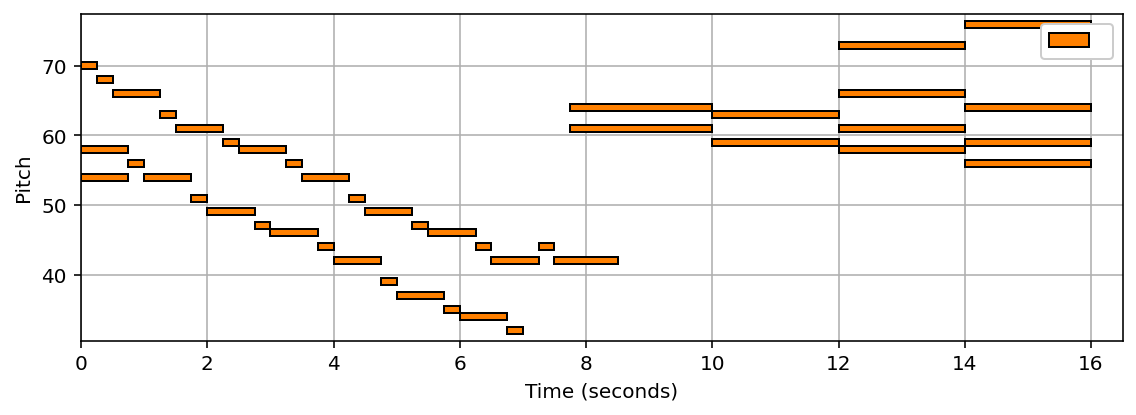

In [15]:
import libfmp.c1
import IPython.display
index = 401 ## 11 66 & 0 & 1 500 omg 1021

'''
ba = ([BATCH, CHN=1, PITCH, TIME], [CSymbollabel], [CChangelabel])
'''
for i,ba in enumerate(dataset["train"]): 
    if i == index: 
        piano_roll = ba[0][0][0] #
        print(piano_roll)

pm = play_and_write(piano_roll , name="test", play=True)
visualize(pm)

#Bidirectional LSTM Defined Here

#Training Settings 

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)




#GO

In [11]:

##START TRAINING 
epochs = 20
batch_size = 40 
num_train_batches = 54320//batch_size #54320 total examples 
num_test_batches = 297//batch_size

status = History(batch_size=batch_size)
AE_ON=True
teststep = 0
trainstep = 0
loss_ae_const = 1
pretrain_AE = 1

for epoch in range(epochs):
    ##~~~~~~~~~~TRAIN~~~~~~~~~~
    for _batchdata in dataset["train"]:
            #AE PASS
            if AE_ON==True:
                aeloss, E_batchdata  = do_AEbatch(_batchdata, autoencoder, AEcriterion, routing_l1_regularization=False)
                autoencoder.distort_prob = max(autoencoder.distort_prob - args['distort_prob_decay'], 0)
            elif AE_ON==False:
                E_batchdata, aeloss = _batchdata, torch.zeros(1).to(device)

            # E_batchdata[0] = E_batchdata[0] + _batchdata[0]
            #LSTM PASS
            if epoch >= pretrain_AE:
                lstmloss, acc = do_LSTMbatch(lstm, E_batchdata, optimizer, LSTMcriterion, device)
            else:
                lstmloss, acc = torch.zeros(1).to(device), 0.0


            #COMBINED LOSS 
            loss = loss_ae_const*aeloss + lstmloss

            #OPTIMIZE
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #STORE HISTORY
            status.addtrainbatch(step=trainstep,
                                 totalloss=round(loss.item(),3), 
                                 LSTMloss=round(lstmloss.item(),3),
                                 AEloss=round(loss_ae_const*aeloss.item(),3),
                                 acc=round(acc,3))
            
            trainstep+=1
            # print(status.TRAIN_step)
    status.print_train_batch(epoch=epoch, num_batches=num_train_batches)

    ##~~~~~~~~~~TEST~~~~~~~~~~
    for _data in dataset["val"]:
            #AE PASS
            if AE_ON==True:
                aeloss, E_batchdata  = do_AEbatch(_data, autoencoder, AEcriterion, routing_l1_regularization=False)
                autoencoder.distort_prob = max(autoencoder.distort_prob - args['distort_prob_decay'], 0)
            elif AE_ON==False:
                E_batchdata, aeloss = _data, torch.zeros(1).to(device)

            # E_batchdata[0] = E_batchdata[0] + _data[0]
            #LSTM PASS
            if epoch >= pretrain_AE:
                lstmloss, acc = do_LSTMbatch(lstm, E_batchdata, optimizer, LSTMcriterion, device)
            else:
                lstmloss, acc = torch.zeros(1).to(device), 0.0

            #COMBINED LOSS 
            loss = loss_ae_const*aeloss + lstmloss

            #STORE HISTORY
            status.addtestbatch(step=teststep,
                                 totalloss=round(loss.item(),3), 
                                 LSTMloss=round(lstmloss.item(),3),
                                 AEloss=round(loss_ae_const*aeloss.item(),3),
                                 acc=round(acc,3))
            teststep+=1

    status.print_test_batch(epoch=epoch, num_batches=num_test_batches)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")



epoch:  0 train_loss:  0.03233726067746686
	 train_AEloss:  0.03233726067746686
	 train_LSTMloss:  0.0
	 train_totalloss:  0.03233726067746686
	 train_acc:  0.0


epoch:  0 test_loss:  0.017142857142857144
	 test_AEloss:  0.017142857142857144
	 test_LSTMloss:  0.0
	 test_totalloss:  0.017142857142857144
	 test_acc:  0.0


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch:  1 train_loss:  1.3752569955817378
	 train_AEloss:  0.04950368188512518
	 train_LSTMloss:  1.3257466863033873
	 train_totalloss:  1.3752569955817378
	 train_acc:  0.5936281296023564


epoch:  1 test_loss:  0.8734285714285714
	 test_AEloss:  0.04757142857142857
	 test_LSTMloss:  0.8258571428571428
	 test_totalloss:  0.8734285714285714
	 test_acc:  0.7512857142857143


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch:  2 train_loss:  0.8235522827687776
	 train_AEloss:  0.043874079528718704
	 train_LSTMloss:  0.7796833578792342
	 train_totalloss:  0.8235522827687776
	 train_acc:  0.7512385861561119


epoch:  2 test_loss:  0.756
	 test_AEloss:  0.0

#Try with validation set

##Helpers

In [14]:
import statistics

def keepTOPkpitch(A, K):
    K = K # Select top K values along each column
    # Sort A, store the argsort for later usage
    sidx = np.argsort(A,axis=0)
    sA = A[sidx,np.arange(A.shape[1])]
    # Perform differentiation along rows and look for non-zero differentiations
    df = np.diff(sA,axis=0)!=0
    # Perform cumulative summation along rows from bottom upwards. 
    # Thus, summations < K should give us a mask of valid ones that are to 
    # be kept per column. Use this mask to set rest as zeros in sorted array.
    mask = (df[::-1].cumsum(0)<K)[::-1]
    sA[:-1] *=mask
    # Finally revert back to unsorted order by using sorted indices sidx
    out = sA[sidx.argsort(0),np.arange(sA.shape[1])]
    return out

def save_batch(x, folder):
    for i in range(x.size(0)):
        d = x[i,0,:,:].detach().cpu().numpy()
        play_and_write(d , folder + str(i), play=False)

    
def _note_count(piano_roll):
    return  float(torch.count_nonzero(piano_roll))

def pitch_diversity(piano_roll):
    return float(torch.std(piano_roll.float()))



# Eval tranformations

In [15]:
os.system("rm -r /content/0.3kwta/ /content/0.5kwta/ /content/0.7kwta/ /content/1.001kwta/ /content/1.3kwta/ /content/1.9kwta/ /content/1.5kwta/")

256

In [16]:
from google.colab import files

##START TRAINING 
batch_size = 40 
num_train_batches = 54320//batch_size #54320 total examples 
num_test_batches = 297//batch_size

teststep = 0
loss_ae_const = 1

for ratio in [0.3,0.5,0.7,1,1.3,1.5,1.9]:
    status = History(batch_size=batch_size)
    folder = str(ratio) + "kwta/"
    os.mkdir(folder)
    for _data in dataset["val"]:
          #BATCH HARMONY TRANFORMATION
          _data[0] = autoencoder.batch_Harmonytransformation(_data[0].to(device), ratio, res=30)
          
          #AE PASS
          aeloss, _data  = do_AEbatch(_data, autoencoder, AEcriterion, routing_l1_regularization=False)

          #LSTM PASS
          lstmloss, acc = do_LSTMbatch(lstm, _data, optimizer, LSTMcriterion, device)

          #COMBINED LOSS 
          loss = loss_ae_const*aeloss + lstmloss

          #STORE HISTORY
          status.addtestbatch(step=teststep,
                                totalloss=round(loss.item(),3), 
                                LSTMloss=round(lstmloss.item(),3),
                                AEloss=round(loss_ae_const*aeloss.item(),3),
                                acc=round(acc,3))
          
          status.add_harmony_tranfomation_metrics(_note_count(_data[0]), pitch_diversity(_data[0]))
          save_batch(_data[0], folder + str(teststep) + "_")
          teststep+=1
    os.system("zip -r " + folder[0:-1] + ".zip " + folder)
    files.download(folder[0:-1] + ".zip")
    status.print_test_batch(epoch=0, num_batches=num_test_batches)
    status.print_harmony_tranfomation_metric()
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


BAD TRASFORM DETECTED 	 target: 0.3 	 actual: 0.5042016806722689
BAD TRASFORM DETECTED 	 target: 0.3 	 actual: 0.5600961538461539
BAD TRASFORM DETECTED 	 target: 0.3 	 actual: 0.5060975609756098
BAD TRASFORM DETECTED 	 target: 0.3 	 actual: 0.5373831775700935
BAD TRASFORM DETECTED 	 target: 0.3 	 actual: 0.7520661157024794
BAD TRASFORM DETECTED 	 target: 0.3 	 actual: 0.5419354838709678
BAD TRASFORM DETECTED 	 target: 0.3 	 actual: 0.5337423312883436
BAD TRASFORM DETECTED 	 target: 0.3 	 actual: 0.5958549222797928
BAD TRASFORM DETECTED 	 target: 0.3 	 actual: 0.5023696682464455
BAD TRASFORM DETECTED 	 target: 0.3 	 actual: 0.5186721991701245
BAD TRASFORM DETECTED 	 target: 0.3 	 actual: 0.6057692307692307
BAD TRASFORM DETECTED 	 target: 0.3 	 actual: 0.5051020408163265
BAD TRASFORM DETECTED 	 target: 0.3 	 actual: 0.5345454545454545
BAD TRASFORM DETECTED 	 target: 0.3 	 actual: 0.5653104925053534
BAD TRASFORM DETECTED 	 target: 0.3 	 actual: 0.5703422053231939


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

epoch:  0 test_loss:  2.559
	 test_AEloss:  0.012714285714285714
	 test_LSTMloss:  2.5462857142857143
	 test_totalloss:  2.559
	 test_acc:  0.44542857142857145


	 note_num:  44120.857142857145
	 pitch_div:  0.12016215707574572


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
BAD TRASFORM DETECTED 	 target: 0.5 	 actual: 0.7520661157024794
BAD TRASFORM DETECTED 	 target: 0.5 	 actual: 0.7714285714285715
BAD TRASFORM DETECTED 	 target: 0.5 	 actual: 0.7375


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

epoch:  0 test_loss:  1.7745714285714287
	 test_AEloss:  0.015428571428571429
	 test_LSTMloss:  1.7587142857142857
	 test_totalloss:  1.7745714285714287
	 test_acc:  0.5897142857142857


	 note_num:  55705.57142857143
	 pitch_div:  0.14624072824205672


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

epoch:  0 test_loss:  1.1838571428571427
	 test_AEloss:  0.019285714285714285
	 test_LSTMloss:  1.1645714285714286
	 test_totalloss:  1.1838571428571427
	 test_acc:  0.6958571428571428


	 note_num:  66221.14285714286
	 pitch_div:  0.17009871772357396


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

epoch:  0 test_loss:  0.8112857142857143
	 test_AEloss:  0.028142857142857143
	 test_LSTMloss:  0.7832857142857143
	 test_totalloss:  0.8112857142857143
	 test_acc:  0.7852857142857143


	 note_num:  74784.28571428571
	 pitch_div:  0.19177165627479553


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

epoch:  0 test_loss:  0.8122857142857143
	 test_AEloss:  0.027285714285714285
	 test_LSTMloss:  0.7848571428571429
	 test_totalloss:  0.8122857142857143
	 test_acc:  0.7868571428571428


	 note_num:  76210.28571428571
	 pitch_div:  0.2588702695710318


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
BAD TRASFORM DETECTED 	 target: 1.5 	 actual: 1.7609561752988048
BAD TRASFORM DETECTED 	 target: 1.5 	 actual: 1.7037037037037037


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

epoch:  0 test_loss:  0.8211428571428572
	 test_AEloss:  0.028285714285714286
	 test_LSTMloss:  0.7928571428571428
	 test_totalloss:  0.8211428571428572
	 test_acc:  0.7825714285714286


	 note_num:  77081.14285714286
	 pitch_div:  0.28877347707748413


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
BAD TRASFORM DETECTED 	 target: 1.9 	 actual: 2.115
BAD TRASFORM DETECTED 	 target: 1.9 	 actual: 2.115
BAD TRASFORM DETECTED 	 target: 1.9 	 actual: 2.103896103896104
BAD TRASFORM DETECTED 	 target: 1.9 	 actual: 2.1779661016949152
BAD TRASFORM DETECTED 	 target: 1.9 	 actual: 2.1373390557939915
BAD TRASFORM DETECTED 	 target: 1.9 	 actual: 2.107142857142857
BAD TRASFORM DETECTED 	 target: 1.9 	 actual: 2.1206896551724137
BAD TRASFORM DETECTED 	 target: 1.9 	 actual: 2.111940298507463
BAD TRASFORM DETECTED 	 target: 1.9 	 actual: 2.104
BAD TRASFORM DETECTED 	 target: 1.9 	 actual: 2.1392405063291138
BAD TRASFORM DETECTED 	 target: 1.9 	 actual: 2.14804469273743
BAD TRASFORM DETECTED 	 target: 1.9 	 actual:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

epoch:  0 test_loss:  0.8804285714285714
	 test_AEloss:  0.03214285714285714
	 test_LSTMloss:  0.8481428571428572
	 test_totalloss:  0.8804285714285714
	 test_acc:  0.7672857142857142


	 note_num:  78238.71428571429
	 pitch_div:  0.33941441774368286


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#Example 1.5 Note multiple

original_roll note_count:  238.0
original_roll pitch_diversity:  0.1679646223783493


piano_roll note_count:  368.0
piano_roll pitch_diversity:  0.20714521408081055


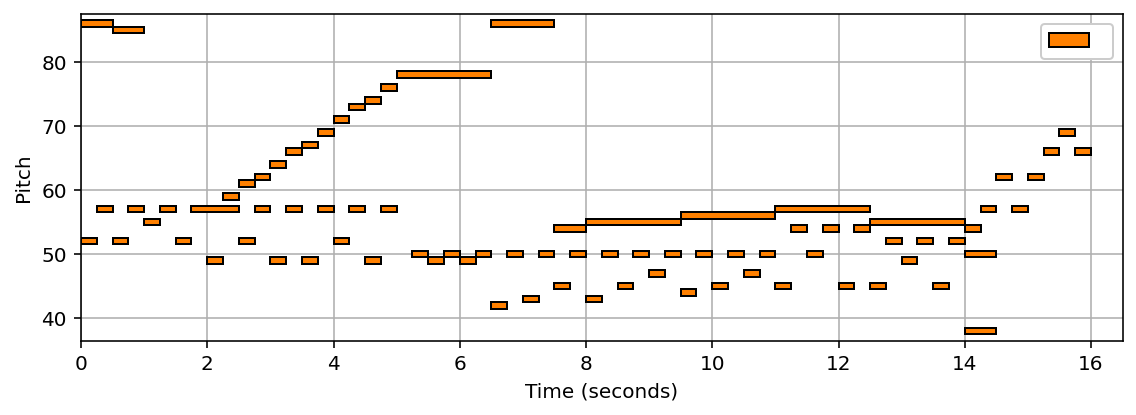

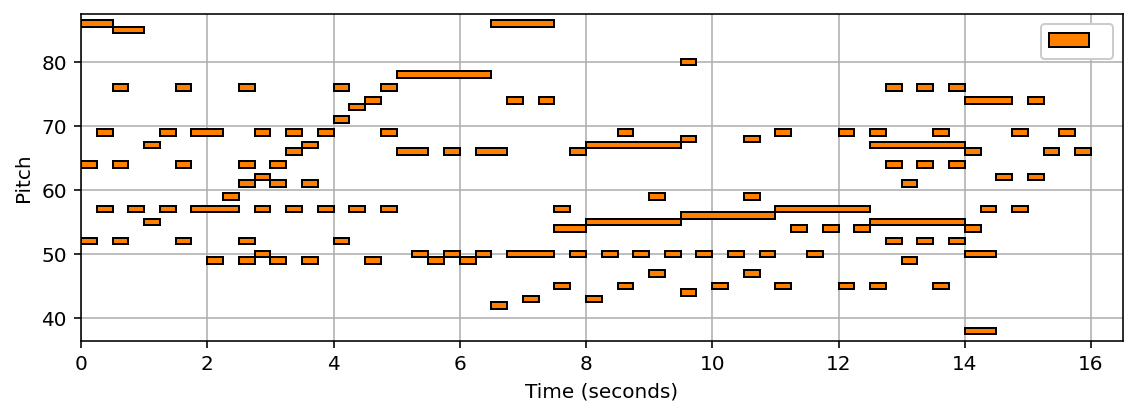

In [17]:

import IPython.display
import libfmp.c1


index = 1 ## 44 66 & 0 & 1 500 omg 1021
# tranform = dataset["train"].dataset.transform["inverse_norm"]
ratio = 1.5
for i,batch in enumerate(dataset["val"]): 
    original = batch[0].to(device)
    t_batch = autoencoder.batch_Harmonytransformation(original, ratio, res=50)
    if i == index: 
        original_roll = original[1][0].detach().cpu()
        piano_roll = t_batch[1][0].detach().cpu()
        break

print("original_roll note_count: ", float(_note_count(original_roll)))
print("original_roll pitch_diversity: ", float(pitch_diversity(original_roll)))
pm = play_and_write(original_roll , name="ORIGINAL")
visualize(pm)


print("piano_roll note_count: ", float(_note_count(piano_roll)))
print("piano_roll pitch_diversity: ", float(pitch_diversity(piano_roll)))
pm = play_and_write(piano_roll , name="ratio1p5")
visualize(pm)



#Same example with 0.7 Note multiple

original_roll note_count:  238.0
original_roll pitch_diversity:  0.1679646223783493


piano_roll note_count:  174.0
piano_roll pitch_diversity:  0.14419300854206085


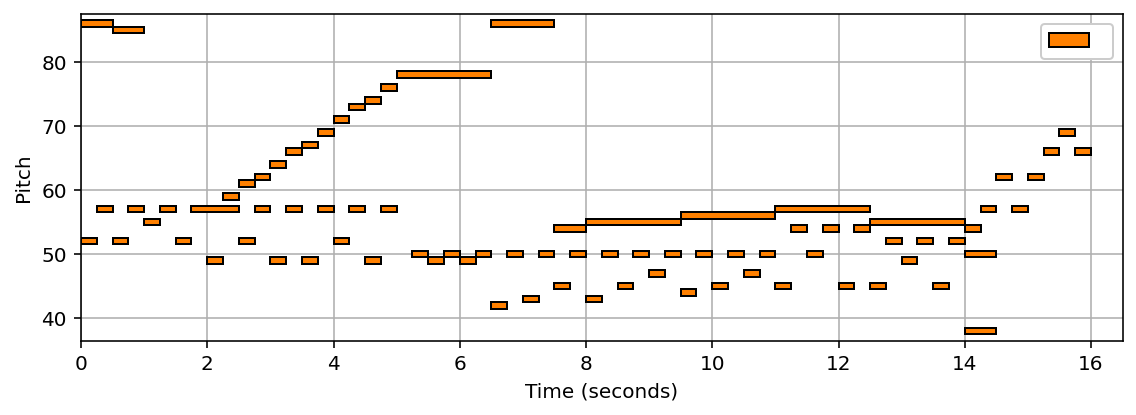

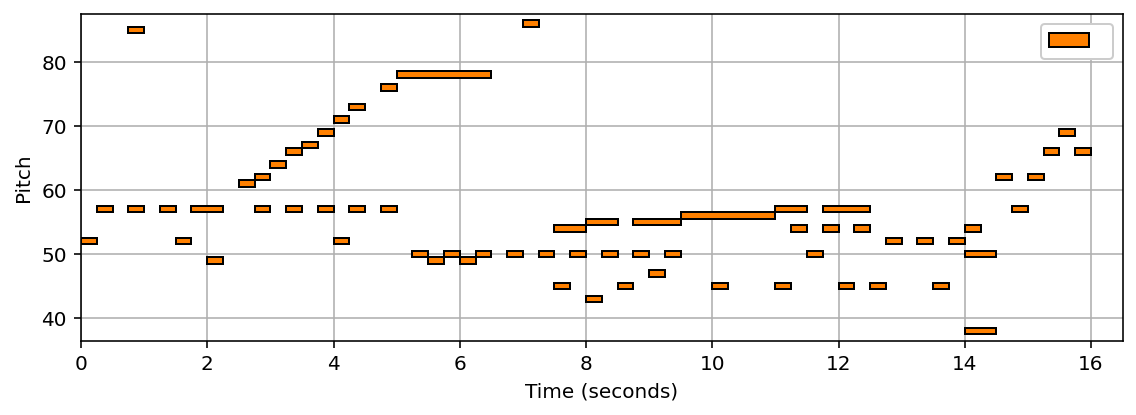

In [18]:

import IPython.display
import libfmp.c1


index = 1 ## 44 66 & 0 & 1 500 omg 1021
# tranform = dataset["train"].dataset.transform["inverse_norm"]
ratio = 0.7
for i,batch in enumerate(dataset["val"]): 
    original = batch[0].to(device)
    t_batch = autoencoder.batch_Harmonytransformation(original, ratio, res=50)
    if i == index: 
        original_roll = original[1][0].detach().cpu()
        piano_roll = t_batch[1][0].detach().cpu()
        break

print("original_roll note_count: ", float(_note_count(original_roll)))
print("original_roll pitch_diversity: ", float(pitch_diversity(original_roll)))
pm = play_and_write(original_roll , name="ORIGINAL")
visualize(pm)


print("piano_roll note_count: ", float(_note_count(piano_roll)))
print("piano_roll pitch_diversity: ", float(pitch_diversity(piano_roll)))
pm = play_and_write(piano_roll , name="ratio0p7")
visualize(pm)



In [19]:
%load_ext autoreload
%autoreload 2